**Simple Clustering Approach**

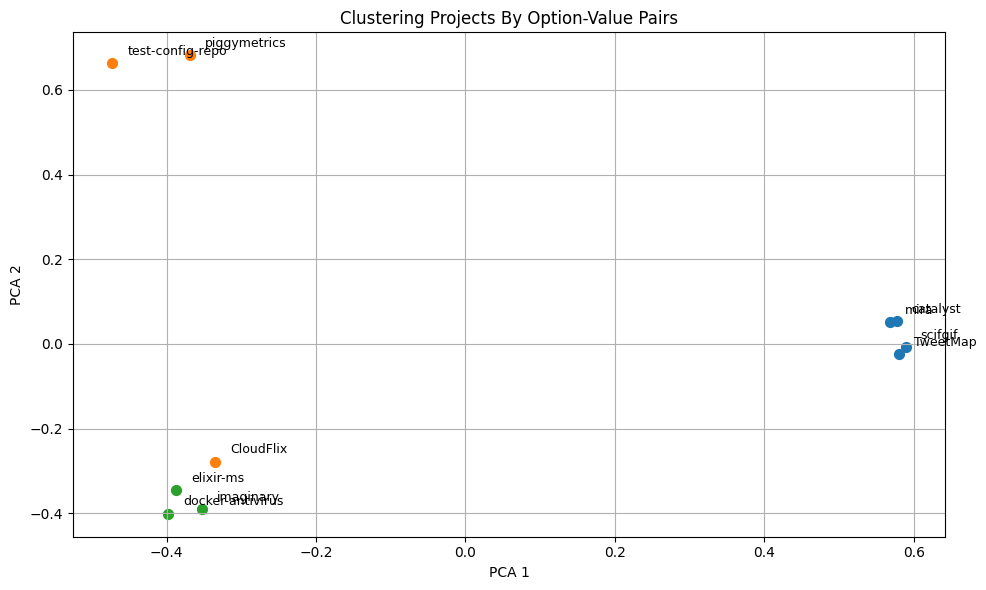

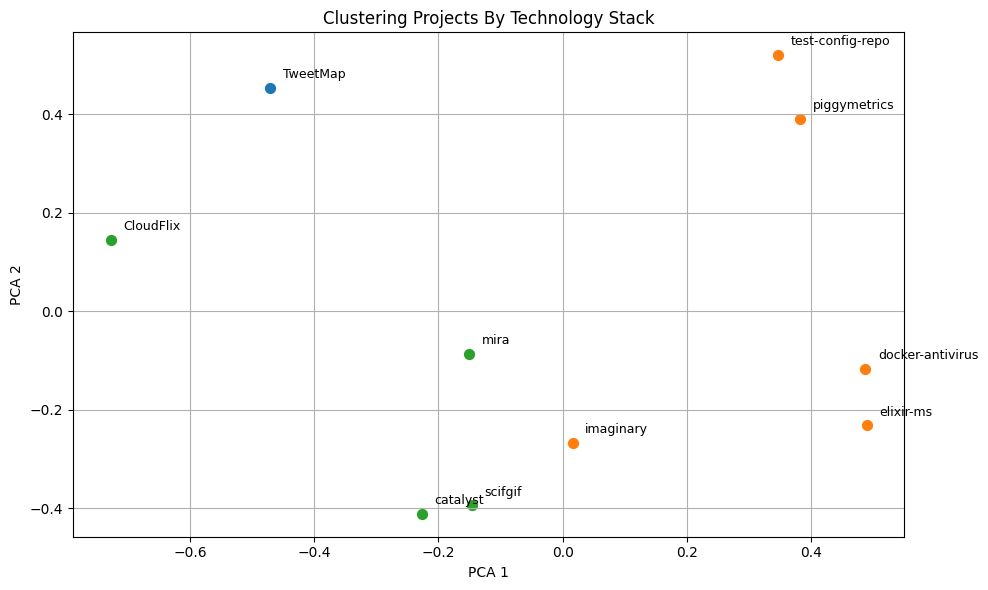

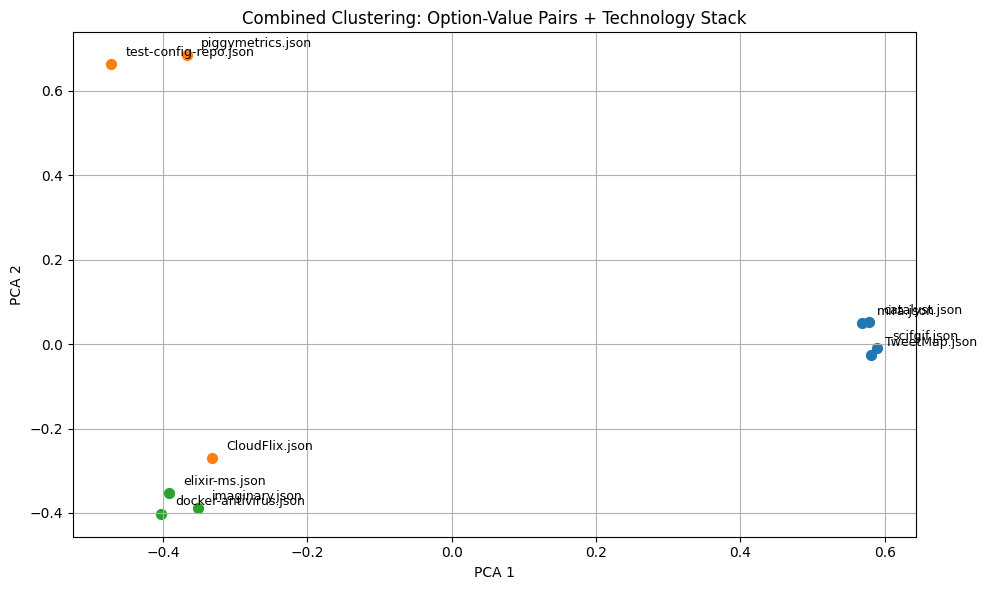

In [1]:
import json
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def load_projects_from_folder(folder_path):
    project_jsons = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".json"):
            with open(os.path.join(folder_path, file_name), "r", encoding="utf-8") as f:
                project_jsons.append((file_name, json.load(f)))
    return project_jsons


def get_latest_commit(project_data):
    return next(filter(lambda commit: commit["is_latest_commit"], project_data["commit_data"]))


def extract_config_space_from_latest_commit(project_data):
    latest_commit = get_latest_commit(project_data=project_data)
    
    options = []
    for file_data in latest_commit["network_data"]["config_file_data"]:
        for pair in file_data["pairs"]:
            option = pair["option"]
            value = pair["value"]
            options.append(f"{option}={value}")
    return options


def extract_tech_stack_from_latest_commit(project_data):
    latest_commit = get_latest_commit(project_data=project_data)
    technologies = latest_commit["network_data"].get("concepts", [])
    return technologies


def extract_combined_features(project_data):
    latest_commit = get_latest_commit(project_data=project_data)
    
    # Option-value pairs
    config_text = " ".join(
        f"{pair['option']}={pair['value']}"
        for file_data in latest_commit["network_data"]["config_file_data"]
        for pair in file_data["pairs"]
    )

    # Technology stack
    tech_text = " ".join(latest_commit["network_data"].get("concepts", []))

    return config_text + " " + tech_text


def cluster_projects_by_options(project_jsons, n_clusters=3):
    project_texts = []
    project_names = []

    for name, proj in project_jsons:
        config_data = extract_config_space_from_latest_commit(proj)
        if config_data:
            project_texts.append(" ".join(config_data))
            project_names.append(name.split(".json")[0])

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(project_texts)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(X.toarray())

    return reduced, labels, project_names


def cluster_projects_by_technologies(project_jsons, n_clusters=3):
    project_texts = []
    project_names = []

    for name, proj in project_jsons:
        tech_stack = extract_tech_stack_from_latest_commit(proj)
        if tech_stack:
            project_texts.append(" ".join(tech_stack))
            project_names.append(name.split(".json")[0])

    if not project_texts:
        raise ValueError("No technology data found for clustering.")

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(project_texts)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(X.toarray())

    return reduced, labels, project_names


def cluster_projects_combined(project_jsons, n_clusters=3):
    project_texts = []
    project_names = []

    for name, proj in project_jsons:
        combined_text = extract_combined_features(proj)
        if combined_text.strip():
            project_texts.append(combined_text)
            project_names.append(name)

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(project_texts)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(X.toarray())

    return reduced, labels, project_names


def plot_clusters(reduced, labels, names, title):
    plt.figure(figsize=(10, 6))

    # Plot points by cluster color
    for i in range(len(names)):
        plt.scatter(reduced[i, 0], reduced[i, 1], c=f"C{labels[i]}", s=50)
        plt.text(reduced[i, 0] + 0.02, reduced[i, 1] + 0.02, names[i], fontsize=9)

    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

folder_path = "../data/test_projects"  
project_jsons = load_projects_from_folder(folder_path)
reduced, labels, names = cluster_projects_by_options(project_jsons=project_jsons, n_clusters=3)
plot_clusters(reduced, labels, names, "Clustering Projects By Option-Value Pairs")

reduced, labels, names = cluster_projects_by_technologies(project_jsons=project_jsons, n_clusters=3)
plot_clusters (reduced, labels, names, "Clustering Projects By Technology Stack")

reduced, labels, names = cluster_projects_combined(project_jsons, n_clusters=3)
plot_clusters(reduced, labels, names, "Combined Clustering: Option-Value Pairs + Technology Stack")



    

**Technology Stack Clustering**
This approach groups software projects based on the technologies they use, such as frameworks, databases, or CI/CD tools. Each project's technology stack is represented as a binary feature vector indicating the presence or absence of known technologies. Clustering is then performed using cosine similarity and dimensionality reduction, revealing groups of projects that share similar technical ecosystems.

**Option-Value Pair Clustering**
In this approach, projects are clustered based on the specific configuration options and their assigned values. Each project's configuration is transformed into a textual representation of option=value pairs and vectorized using TF-IDF to capture semantic similarities. Clustering on these vectors uncovers groups of projects that configure their systems in similar ways, independent of the underlying technologies.

**Combined Clustering**
The combined approach integrates both technology stack and option-value data into a unified feature space. It merges binary technology indicators with TF-IDF representations of configuration settings, enabling clustering based on both what technologies a project uses and how those technologies are configured. This holistic view captures nuanced relationships between technical choices and configuration behaviors, leading to more meaningful project groupings.

['../data/test_projects/yt-dlp.json', '../data/test_projects/axios.json', '../data/test_projects/piggymetrics.json', '../data/test_projects/neovim.json', '../data/test_projects/tauri.json', '../data/test_projects/gpt4all.json', '../data/test_projects/whisper.json', '../data/test_projects/test-config-repo.json', '../data/test_projects/json-server.json', '../data/test_projects/github-readme-stats.json', '../data/test_projects/mall.json']
Running Technology Stack Clustering...
Extracted features for 11 projects

Running Option-Value Clustering...


/var/folders/sv/pdgl__6900j8c78ybv1j2hjw0000gp/T/ipykernel_32156/3560227970.py:407: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Extracted features for 11 projects

Running Combined Clustering...


/var/folders/sv/pdgl__6900j8c78ybv1j2hjw0000gp/T/ipykernel_32156/3560227970.py:407: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Extracted features for 11 projects


/var/folders/sv/pdgl__6900j8c78ybv1j2hjw0000gp/T/ipykernel_32156/3560227970.py:407: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()



Running Technology Ecosystem Clustering...
Technology Stack Clustering:
Technology Stack Clustering Report

KMEANS Technology Clustering Results:
----------------------------------------
Cluster 4 (1 projects):
  Projects: yt-dlp
  Common Technologies: poetry, github-action, yaml, json, docker, ansible-playbook
  All Technologies: {'poetry': 1, 'github-action': 1, 'yaml': 1, 'json': 1, 'docker': 1}

Cluster 2 (3 projects):
  Projects: axios, gpt4all, json-server
  Common Technologies: nodejs, json, github-action, yaml
  All Technologies: {'tsconfig': 2, 'github-action': 3, 'yaml': 3, 'nodejs': 3, 'json': 3}

Cluster 1 (3 projects):
  Projects: piggymetrics, test-config-repo, mall
  Common Technologies: docker, maven, spring, docker-compose
  All Technologies: {'maven': 3, 'yaml': 2, 'docker-compose': 3, 'docker': 3, 'spring': 3}

Cluster 3 (3 projects):
  Projects: neovim, whisper, github-readme-stats
  Common Technologies: json, github-action, yaml
  All Technologies: {'json': 3, 'to

/var/folders/sv/pdgl__6900j8c78ybv1j2hjw0000gp/T/ipykernel_32156/3560227970.py:407: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


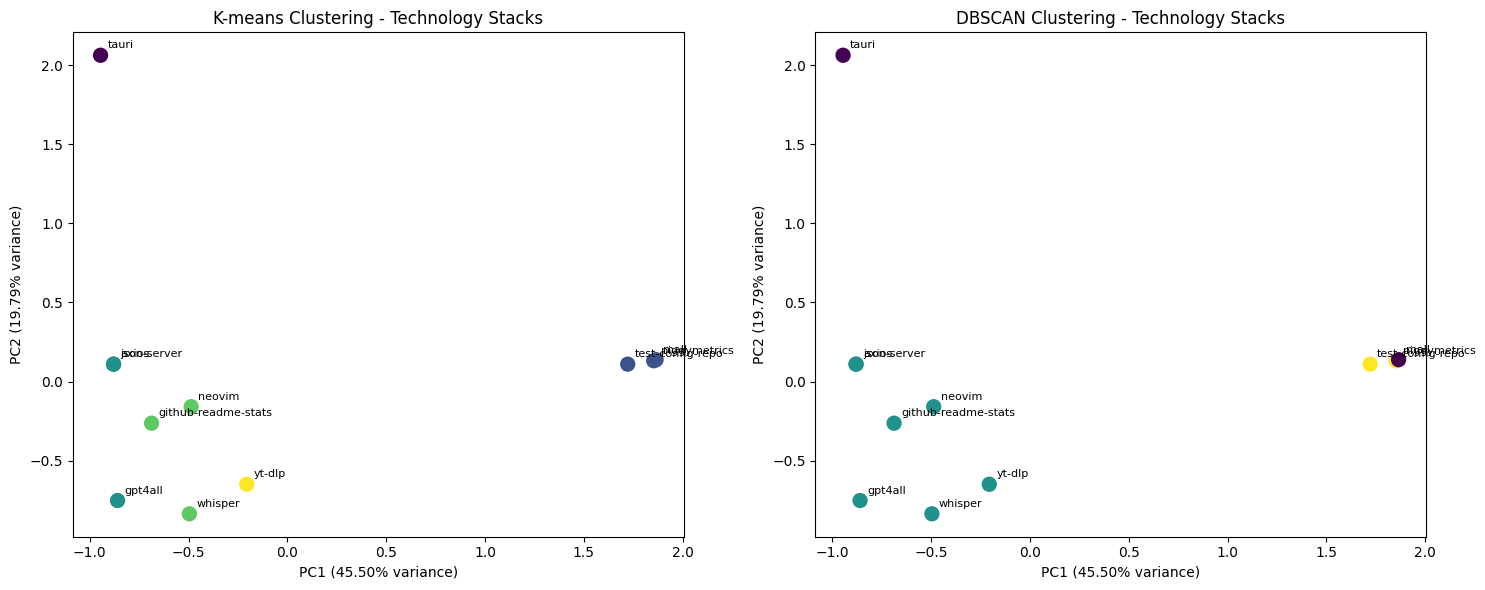

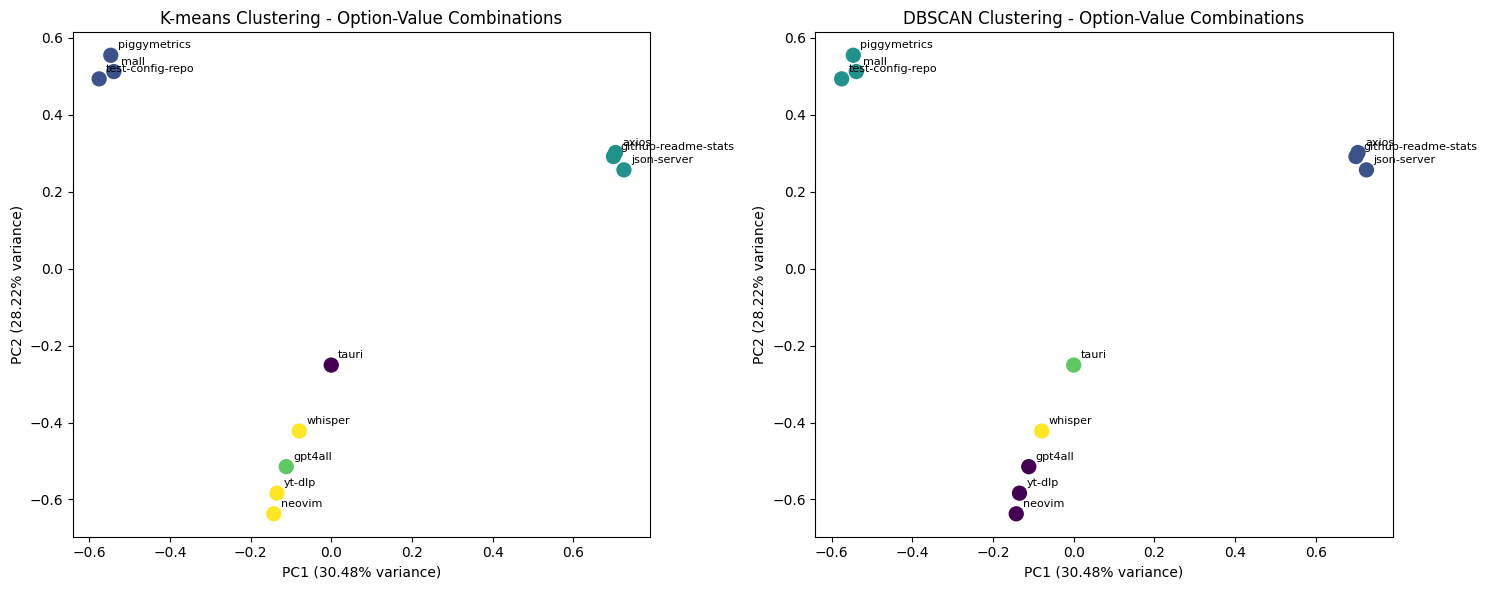

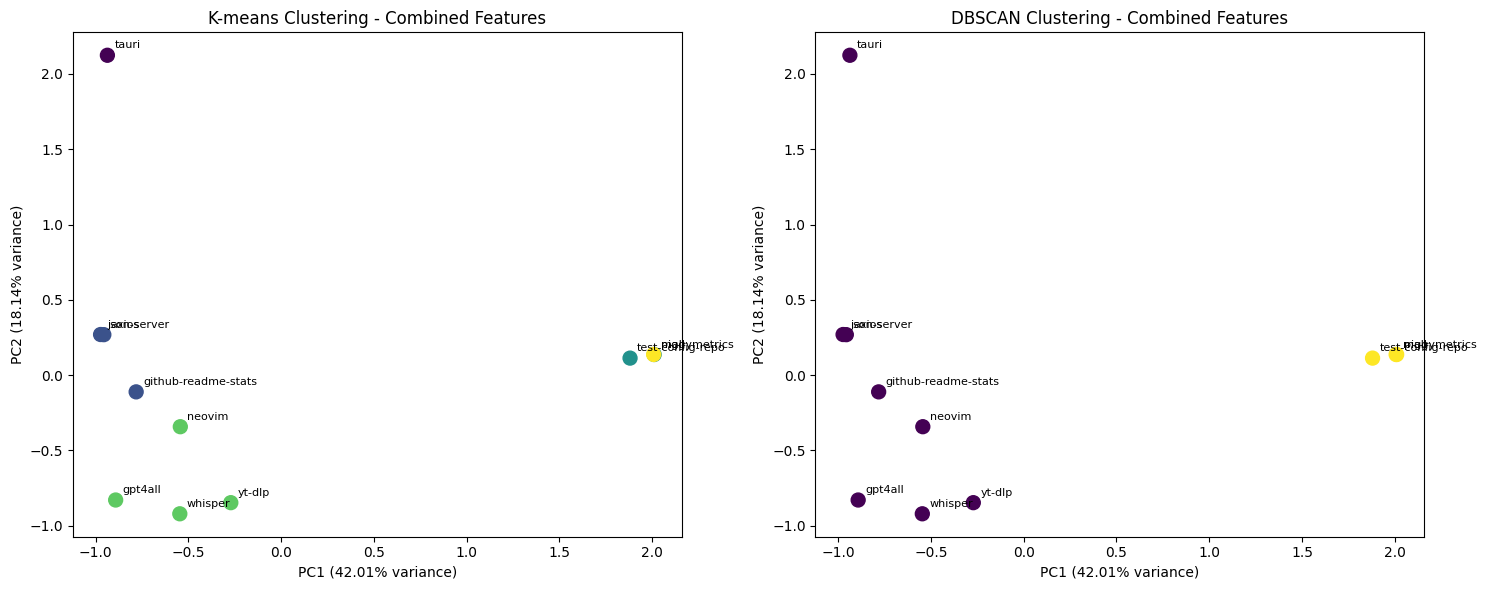

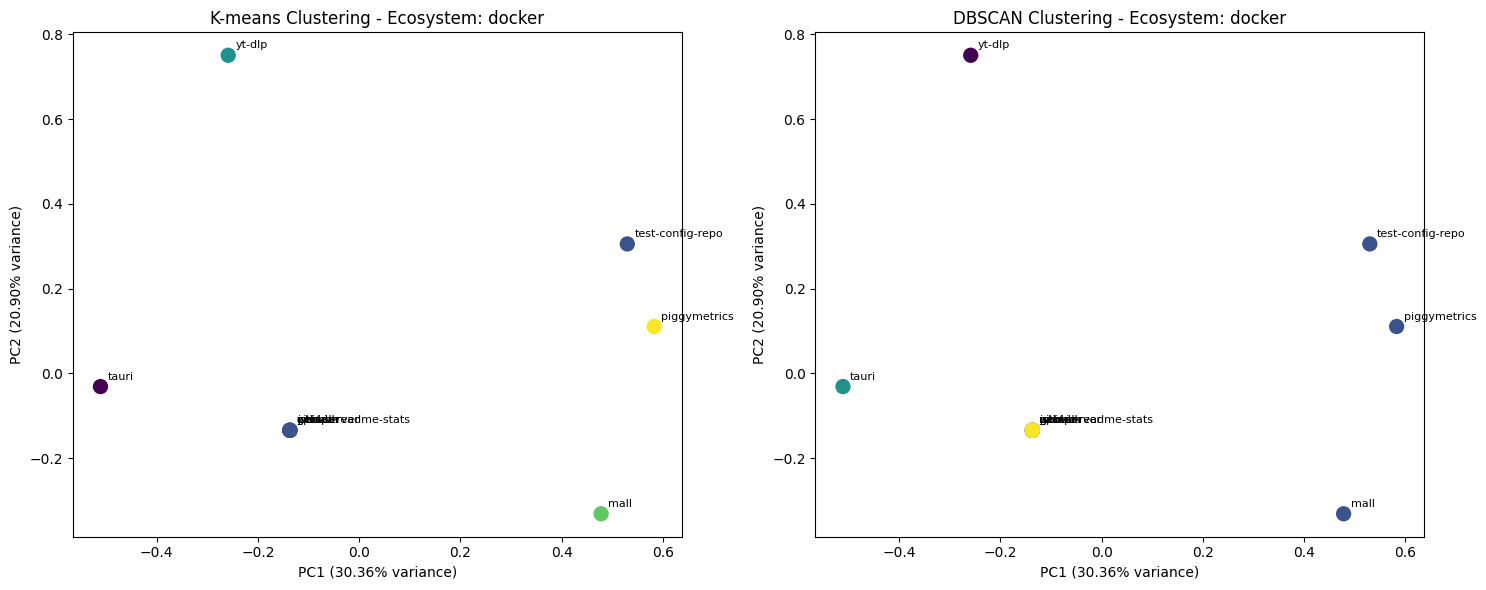

In [12]:
import json
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Any
import glob

class ConfigurationSpaceClusterer:
    def __init__(self):
        self.projects_data = []
        self.scaler = StandardScaler()
        
    def load_project_data(self, file_paths: List[str]):
        """Load configuration data from multiple project JSON files"""
        for file_path in file_paths:
            with open(file_path, 'r') as f:
                project_data = json.load(f)
                # Extract latest commit data
                latest_commit = self._get_latest_commit(project_data)
                if latest_commit:
                    self.projects_data.append({
                        'project_name': project_data['project_name'],
                        'latest_commit': latest_commit
                    })
    
    def _get_latest_commit(self, project_data: Dict) -> Dict:
        """Extract the latest commit from project data"""
        return next(filter(lambda commit: commit["is_latest_commit"], project_data['commit_data']))
    
    def extract_features(self) -> pd.DataFrame:
        """Extract features from configuration spaces for clustering"""
        features = []
        
        for project in self.projects_data:
            project_name = project['project_name']
            commit_data = project['latest_commit']['network_data']
            
            # Technology stack features
            concepts = set(commit_data.get('concepts', []))
            
            # Option-value combinations (like the simple script)
            option_value_pairs = []
            for file_data in commit_data.get('config_file_data', []):
                for pair in file_data.get('pairs', []):
                    option = pair.get('option', '')
                    value = pair.get('value', '')
                    if option and value:
                        option_value_pairs.append(f"{option}={value}")
            
            features.append({
                'project_name': project_name,
                'concepts': list(concepts),
                'option_value_pairs': option_value_pairs,
            })
        
        return pd.DataFrame(features)
    
    def extract_technology_features(self, technology_name: str) -> pd.DataFrame:
        """Extract features from configuration spaces for a given technologyfor clustering"""
        features = []
        
        for project in self.projects_data:
            project_name = project['project_name']
            commit_data = project['latest_commit']['network_data']
            
            # Technology stack features
            concepts = set(commit_data.get('concepts', []))
            
            # Option-value combinations (like the simple script)
            option_value_pairs = []
            for file_data in commit_data.get('config_file_data', []):
                if file_data.get('concept') == technology_name:
                    for pair in file_data.get('pairs', []):
                        option = pair.get('option', '')
                        value = pair.get('value', '')
                        if option and value:
                            option_value_pairs.append(f"{option}={value}")
            
            features.append({
                'project_name': project_name,
                'concept': list(concepts),
                'option_value_pairs': option_value_pairs,
            })
        
        return pd.DataFrame(features)

    def cluster_technology_ecosystems(self, technology_name: str, n_clusters: int = 3) -> Dict:
        tech_df = self.extract_technology_features(technology_name)
        if tech_df.empty:
            raise ValueError(f"No relevant config found for technology: {technology_name}")
        return self.cluster_option_values(tech_df, n_clusters, technology_name)
    
    def cluster_technology_stacks(self, features_df: pd.DataFrame, n_clusters: int = 3):
        """Cluster projects based on technology stacks only"""
        
        # Create technology similarity matrix
        all_concepts = set()
        for concepts in features_df['concepts']:
            all_concepts.update(concepts)
        
        tech_matrix = []
        for _, row in features_df.iterrows():
            tech_vector = [1 if concept in row['concepts'] else 0 
                          for concept in sorted(all_concepts)]
            tech_matrix.append(tech_vector)
        
        tech_features = np.array(tech_matrix)
        tech_similarity = cosine_similarity(tech_features)
        
        # K-means clustering on technology vectors
        svd = TruncatedSVD(n_components=2, random_state=42)
        reduced_tech = svd.fit_transform(tech_features)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_labels = kmeans.fit_predict(reduced_tech)
                
        # DBSCAN clustering on technology vectors
        distance_matrix = cosine_distances(tech_features)
        dbscan = DBSCAN(eps=0.3, min_samples=2, metric='precomputed')
        dbscan_labels = dbscan.fit_predict(distance_matrix)
        
        project_names = features_df['project_name'].tolist()
        
        return {
            'type': 'technology_stack',
            'features': tech_features,
            'similarity_matrix': tech_similarity,
            'feature_names': sorted(all_concepts),
            'kmeans': {
                'labels': kmeans_labels,
                'projects': project_names,
                'clusters': self._group_by_clusters(project_names, kmeans_labels)
            },
            'dbscan': {
                'labels': dbscan_labels,
                'projects': project_names,
                'clusters': self._group_by_clusters(project_names, dbscan_labels)
            }
        }
    
    def cluster_option_values(self, features_df: pd.DataFrame, n_clusters: int = 3, technology_name: str = None):
        """Cluster projects based on option-value combinations"""
        
        # Create TF-IDF vectors from option-value pairs
        project_texts = []
        for _, row in features_df.iterrows():
            project_texts.append(' '.join(row['option_value_pairs']))
        
        # TF-IDF vectorization
        tfidf = TfidfVectorizer(max_features=200, stop_words=None)
        tfidf_matrix = tfidf.fit_transform(project_texts)
        option_features = tfidf_matrix.toarray()
        option_similarity = cosine_similarity(tfidf_matrix)
        
        # K-means clustering on option-value vectors
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_labels = kmeans.fit_predict(option_features)
        
        # DBSCAN clustering on option-value vectors
        dbscan = DBSCAN(eps=0.7, min_samples=1, metric='cosine')
        dbscan_labels = dbscan.fit_predict(option_features)
        
        project_names = features_df['project_name'].tolist()
        
        return {
            'type': 'option_value',
            'features': option_features,
            'similarity_matrix': option_similarity,
            'feature_names': tfidf.get_feature_names_out(),
            'kmeans': {
                'labels': kmeans_labels,
                'projects': project_names,
                'clusters': self._group_by_clusters(project_names, kmeans_labels)
            },
            'dbscan': {
                'labels': dbscan_labels,
                'projects': project_names,
                'clusters': self._group_by_clusters(project_names, dbscan_labels)
            }
        }
    
    def cluster_combined_features(self, features_df: pd.DataFrame, n_clusters: int = 3):
        """Cluster projects based on combined tech stack and option-value pairs"""
        
        # Prepare tech stack vectors (binary one-hot)
        all_concepts = sorted(set(concept for concepts in features_df['concepts'] for concept in concepts))
        tech_matrix = []
        for _, row in features_df.iterrows():
            tech_vector = [1 if concept in row['concepts'] else 0 for concept in all_concepts]
            tech_matrix.append(tech_vector)
        tech_features = np.array(tech_matrix)

        # Prepare option-value vectors (TF-IDF)
        project_texts = [' '.join(row['option_value_pairs']) for _, row in features_df.iterrows()]
        tfidf = TfidfVectorizer(max_features=200)
        option_features = tfidf.fit_transform(project_texts)

        # Combine both 
        combined_features = hstack([tech_features, option_features])  # sparse format

        # Dimensionality reduction
        svd = TruncatedSVD(n_components=20, random_state=42)
        reduced_features = svd.fit_transform(combined_features)

        # KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_labels = kmeans.fit_predict(reduced_features)

        # DBSCAN clustering
        distance_matrix = cosine_distances(combined_features)
        dbscan = DBSCAN(eps=0.5, min_samples=2, metric='precomputed')
        dbscan_labels = dbscan.fit_predict(distance_matrix)

        project_names = features_df['project_name'].tolist()

        return {
            'type': 'combined',
            'features': combined_features,
            'similarity_matrix': cosine_similarity(combined_features),
            'feature_names': all_concepts + list(tfidf.get_feature_names_out()),
            'kmeans': {
                'labels': kmeans_labels,
                'projects': project_names,
                'clusters': self._group_by_clusters(project_names, kmeans_labels)
            },
            'dbscan': {
                'labels': dbscan_labels,
                'projects': project_names,
                'clusters': self._group_by_clusters(project_names, dbscan_labels)
            }
        }


    def _group_by_clusters(self, project_names: List[str], labels: np.ndarray) -> Dict:
        """Group projects by cluster labels"""
        clusters = defaultdict(list)
        for project, label in zip(project_names, labels):
            clusters[label].append(project)
        return dict(clusters)
    
    def analyze_technology_overlaps(self, features_df: pd.DataFrame, clustering_results: Dict) -> Dict:
        """Analyze technology overlaps between clusters"""
        
        overlaps = {}
        
        for method in ['kmeans', 'dbscan']:
            method_overlaps = {}
            clusters = clustering_results[method]['clusters']
            
            for cluster_id, projects in clusters.items():
                if cluster_id == -1:  # Skip noise cluster in DBSCAN
                    continue
                    
                # Find common technologies
                cluster_projects = features_df[features_df['project_name'].isin(projects)]
                
                common_concepts = set(cluster_projects.iloc[0]['concepts'])
                for _, project in cluster_projects.iterrows():
                    common_concepts &= set(project['concepts'])
                
                # Count all technologies in cluster
                all_concepts = []
                for _, project in cluster_projects.iterrows():
                    all_concepts.extend(project['concepts'])
                
                concept_counts = Counter(all_concepts)
                
                method_overlaps[cluster_id] = {
                    'projects': projects,
                    'common_technologies': list(common_concepts),
                    'all_technologies': dict(concept_counts),
                    'size': len(projects)
                }
            
            overlaps[method] = method_overlaps
        
        return overlaps
    
    def analyze_option_value_overlaps(self, features_df: pd.DataFrame, clustering_results: Dict) -> Dict:
        """Analyze option-value overlaps between clusters"""
        
        overlaps = {}
        
        for method in ['kmeans', 'dbscan']:
            method_overlaps = {}
            clusters = clustering_results[method]['clusters']
            
            for cluster_id, projects in clusters.items():
                if cluster_id == -1:  # Skip noise cluster in DBSCAN
                    continue
                    
                # Find common option-value pairs
                cluster_projects = features_df[features_df['project_name'].isin(projects)]
                
                all_pairs = []
                for _, project in cluster_projects.iterrows():
                    all_pairs.extend(project['option_value_pairs'])
                
                pair_counts = Counter(all_pairs)
                frequent_pairs = {pair: count for pair, count in pair_counts.items() 
                                if count > len(projects) * 0.5}  # Appears in >50% of projects
                
                method_overlaps[cluster_id] = {
                    'projects': projects,
                    'frequent_option_values': frequent_pairs,
                    'all_option_values': dict(pair_counts.most_common(10)),
                    'size': len(projects)
                }
            
            overlaps[method] = method_overlaps
        
        return overlaps
    
    def analyze_combined_overlaps(self, features_df: pd.DataFrame, clustering_results: Dict) -> Dict:
        """Analyze overlaps of both technologies and option-values in combined clusters"""
        
        overlaps = {}
        
        for method in ['kmeans', 'dbscan']:
            method_overlaps = {}
            clusters = clustering_results[method]['clusters']
            
            for cluster_id, projects in clusters.items():
                if cluster_id == -1:
                    continue  # skip noise
                
                cluster_projects = features_df[features_df['project_name'].isin(projects)]

                # === Technology Overlap ===
                common_concepts = set(cluster_projects.iloc[0]['concepts'])
                all_concepts = []
                for _, project in cluster_projects.iterrows():
                    common_concepts &= set(project['concepts'])
                    all_concepts.extend(project['concepts'])
                concept_counts = Counter(all_concepts)

                # === Option-Value Overlap ===
                all_pairs = []
                for _, project in cluster_projects.iterrows():
                    all_pairs.extend(project['option_value_pairs'])
                pair_counts = Counter(all_pairs)
                frequent_pairs = {pair: count for pair, count in pair_counts.items()
                                if count > len(projects) * 0.5}

                method_overlaps[cluster_id] = {
                    'projects': projects,
                    'common_technologies': list(common_concepts),
                    'all_technologies': dict(concept_counts),
                    'frequent_option_values': frequent_pairs,
                    'all_option_values': dict(pair_counts.most_common(10)),
                    'size': len(projects)
                }

            overlaps[method] = method_overlaps

        return overlaps

    
    def visualize_clusters(self, clustering_results: Dict, title_suffix: str = ""):
        """Visualize clustering results"""
        
        features = clustering_results['features']
        
        # PCA for dimensionality reduction
        pca = PCA(n_components=2)
        pca_features = pca.fit_transform(features)
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # K-means visualization
        axes[0].scatter(pca_features[:, 0], pca_features[:, 1], 
                       c=clustering_results['kmeans']['labels'], 
                       cmap='viridis', s=100)
        axes[0].set_title(f'K-means Clustering {title_suffix}')
        axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        
        # Add project labels
        project_names = clustering_results['kmeans']['projects']
        for i, project in enumerate(project_names):
            axes[0].annotate(project, (pca_features[i, 0], pca_features[i, 1]), 
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        # DBSCAN visualization
        axes[1].scatter(pca_features[:, 0], pca_features[:, 1], 
                       c=clustering_results['dbscan']['labels'], 
                       cmap='viridis', s=100)
        axes[1].set_title(f'DBSCAN Clustering {title_suffix}')
        axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        
        # Add project labels
        for i, project in enumerate(project_names):
            axes[1].annotate(project, (pca_features[i, 0], pca_features[i, 1]), 
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        plt.tight_layout()
        fig.show()
        return fig
    
    def generate_technology_report(self, features_df: pd.DataFrame, 
                                 clustering_results: Dict, 
                                 overlaps: Dict) -> str:
        """Generate a technology clustering report"""
        
        report = "Technology Stack Clustering Report\n"
        report += "=" * 50 + "\n\n"
        
        for method in ['kmeans', 'dbscan']:
            report += f"{method.upper()} Technology Clustering Results:\n"
            report += "-" * 40 + "\n"
            
            clusters = clustering_results[method]['clusters']
            method_overlaps = overlaps[method]
            
            for cluster_id, projects in clusters.items():
                if cluster_id == -1:
                    report += f"Noise/Outliers: {projects}\n\n"
                    continue
                
                overlap_info = method_overlaps.get(cluster_id, {})
                
                report += f"Cluster {cluster_id} ({len(projects)} projects):\n"
                report += f"  Projects: {', '.join(projects)}\n"
                report += f"  Common Technologies: {', '.join(overlap_info.get('common_technologies', []))}\n"
                
                all_techs = overlap_info.get('all_technologies', {})
                if all_techs:
                    report += f"  All Technologies: {dict(list(all_techs.items())[:5])}\n"
                report += "\n"
            
            report += "\n"
        
        return report
    
    def generate_option_value_report(self, features_df: pd.DataFrame, 
                                   clustering_results: Dict, 
                                   overlaps: Dict) -> str:
        """Generate an option-value clustering report"""
        
        report = "Option-Value Configuration Clustering Report\n"
        report += "=" * 50 + "\n\n"
        
        for method in ['kmeans', 'dbscan']:
            report += f"{method.upper()} Option-Value Clustering Results:\n"
            report += "-" * 45 + "\n"
            
            clusters = clustering_results[method]['clusters']
            method_overlaps = overlaps[method]
            
            for cluster_id, projects in clusters.items():
                if cluster_id == -1:
                    report += f"Noise/Outliers: {projects}\n\n"
                    continue
                
                overlap_info = method_overlaps.get(cluster_id, {})
                
                report += f"Cluster {cluster_id} ({len(projects)} projects):\n"
                report += f"  Projects: {', '.join(projects)}\n"
                
                frequent_pairs = overlap_info.get('frequent_option_values', {})
                if frequent_pairs:
                    report += f"  Frequent Option-Value Pairs:\n"
                    for pair, count in list(frequent_pairs.items())[:5]:
                        report += f"    - {pair} (appears in {count} projects)\n"
                
                all_pairs = overlap_info.get('all_option_values', {})
                if all_pairs:
                    report += f"  Top Option-Value Pairs:\n"
                    for pair, count in list(all_pairs.items())[:3]:
                        report += f"    - {pair} ({count} times)\n"
                report += "\n"
            
            report += "\n"
        
        return report
    
    def generate_combined_report(self, features_df: pd.DataFrame, clustering_results: Dict, overlaps: Dict) -> str:
        """Generate report for combined technology + option-value clustering"""
        
        report = "Combined Configuration Space Clustering Report\n"
        report += "=" * 60 + "\n\n"
        
        for method in ['kmeans', 'dbscan']:
            report += f"{method.upper()} Combined Clustering Results:\n"
            report += "-" * 50 + "\n"
            
            clusters = clustering_results[method]['clusters']
            method_overlaps = overlaps[method]
            
            for cluster_id, projects in clusters.items():
                if cluster_id == -1:
                    report += f"Noise/Outliers: {projects}\n\n"
                    continue
                
                overlap_info = method_overlaps.get(cluster_id, {})
                report += f"Cluster {cluster_id} ({len(projects)} projects):\n"
                report += f"  Projects: {', '.join(projects)}\n"
                
                if overlap_info.get('common_technologies'):
                    report += f"  Common Technologies: {', '.join(overlap_info['common_technologies'])}\n"
                if overlap_info.get('frequent_option_values'):
                    report += "  Frequent Option-Value Pairs:\n"
                    for pair, count in list(overlap_info['frequent_option_values'].items())[:5]:
                        report += f"    - {pair} (appears in {count} projects)\n"
                report += "\n"

            report += "\n"
        
        return report


# Example usage functions
def cluster_technology_stacks(project_files: List[str], n_clusters: int = 3):
    """Cluster projects based on technology stacks only"""
    
    clusterer = ConfigurationSpaceClusterer()
    clusterer.load_project_data(project_files)
    
    features_df = clusterer.extract_features()
    print(f"Extracted features for {len(features_df)} projects")
    
    # Technology stack clustering
    tech_results = clusterer.cluster_technology_stacks(features_df, n_clusters)
    tech_overlaps = clusterer.analyze_technology_overlaps(features_df, tech_results)
    
    # Generate visualizations and report
    tech_fig = clusterer.visualize_clusters(tech_results, "- Technology Stacks")
    tech_report = clusterer.generate_technology_report(features_df, tech_results, tech_overlaps)
    
    return {
        'features': features_df,
        'clustering_results': tech_results,
        'overlaps': tech_overlaps,
        'visualization': tech_fig,
        'report': tech_report
    }

def cluster_option_values(project_files: List[str], n_clusters: int = 3):
    """Cluster projects based on option-value combinations only"""
    
    clusterer = ConfigurationSpaceClusterer()
    clusterer.load_project_data(project_files)
    
    features_df = clusterer.extract_features()
    print(f"Extracted features for {len(features_df)} projects")
    
    # Option-value clustering
    option_results = clusterer.cluster_option_values(features_df, n_clusters)
    option_overlaps = clusterer.analyze_option_value_overlaps(features_df, option_results)
    
    # Generate visualizations and report
    option_fig = clusterer.visualize_clusters(option_results, "- Option-Value Combinations")
    option_report = clusterer.generate_option_value_report(features_df, option_results, option_overlaps)
    
    return {
        'features': features_df,
        'clustering_results': option_results,
        'overlaps': option_overlaps,
        'visualization': option_fig,
        'report': option_report
    }

def cluster_combined_features(project_files: List[str], n_clusters: int = 3):
    clusterer = ConfigurationSpaceClusterer()
    clusterer.load_project_data(project_files)

    features_df = clusterer.extract_features()
    print(f"Extracted features for {len(features_df)} projects")

    combined_results = clusterer.cluster_combined_features(features_df, n_clusters)
    overlaps = clusterer.analyze_combined_overlaps(features_df, combined_results)
    fig = clusterer.visualize_clusters(combined_results, "- Combined Features")
    report = clusterer.generate_combined_report(features_df, combined_results, overlaps)

    return {
        'features': features_df,
        'clustering_results': combined_results,
        'overlaps': overlaps,
        'visualization': fig,
        'report': report
    }


def cluster_technology_ecosystem(project_files: List[str], technology: str, n_clusters: int = 3):
    clusterer = ConfigurationSpaceClusterer()
    clusterer.load_project_data(project_files)

    tech_df = clusterer.extract_technology_features(technology)
    if tech_df.empty:
        raise ValueError(f"No relevant config found for technology: {technology}")

    clustering_result = clusterer.cluster_option_values(tech_df, n_clusters)
    overlaps = clusterer.analyze_option_value_overlaps(tech_df, clustering_result)
    report = clusterer.generate_option_value_report(tech_df, clustering_result, overlaps)
    fig = clusterer.visualize_clusters(clustering_result, f"- Ecosystem: {technology}")

    return {
        'features': tech_df,
        'clustering_results': clustering_result,
        'overlaps': overlaps,
        'visualization': fig,
        'report': report
    }


def run_all_clustering_approaches(project_files: List[str], n_clusters: int = 3):
    """Run both technology stack and option-value clustering"""
    
    print("Running Technology Stack Clustering...")
    tech_stack_results = cluster_technology_stacks(project_files, n_clusters)
    
    print("\nRunning Option-Value Clustering...")
    option_results = cluster_option_values(project_files, n_clusters)

    print("\nRunning Combined Clustering...")
    combined_results = cluster_combined_features(project_files, n_clusters)

    print("\nRunning Technology Ecosystem Clustering...")
    tech_ecosystem_results = cluster_technology_ecosystem(project_files, "docker", n_clusters)
    
    return {
        'techn_stack': tech_stack_results,
        'option_value': option_results,
        'combined': combined_results,
        'tech_ecosystem': tech_ecosystem_results
    }


project_files = glob.glob("../data/test_projects/*.json")
print(project_files)

# Run both clustering approaches
results = run_all_clustering_approaches(project_files, n_clusters=5)

print("Technology Stack Clustering:")
print(results['techn_stack']['report'])

print("\nOption-Value Clustering:")
print(results['option_value']['report']) 

print("\nCombined Clustering:")
print(results['combined']['report'])

print("\nTechnology Ecosystem Clustering:")
print(results['tech_ecosystem']['report'])

**Silhouette Score**
| Silhouette Score | Interpretation                                |
| ---------------- | --------------------------------------------- |
| **0.71 – 1.00**  | Strong structure; clusters are well-separated |
| **0.51 – 0.70**  | Reasonable structure                          |
| **0.26 – 0.50**  | Weak structure; clusters may overlap          |
| **0.00 – 0.25**  | No substantial structure (random or noise)    |
| **< 0.00**       | Potential misassignments; reconsider `k`      |

**Elbow Method**
| Pattern                | Meaning                                                               |
| ---------------------- | --------------------------------------------------------------------- |
| Sharp elbow, then flat | Good indication of optimal `k`                                        |
| No clear elbow         | Data may not cluster well or too uniform                              |
| Elbow around small `k` | Few distinct groups in data (simple structure)                        |
| Elbow at high `k`      | Complex structure; be cautious of overfitting or very sparse clusters |


Best k based on silhouette score: 4
Silhouette scores by k:
  k=2: 0.0029
  k=3: 0.3500
  k=4: 0.4682
  k=5: 0.4099
  k=6: 0.3353
  k=7: 0.3276
  k=8: 0.3371
  k=9: 0.2111


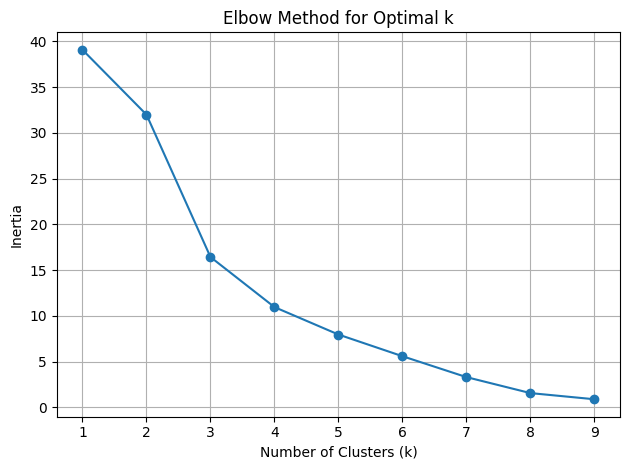


Cluster assignments:
                project  cluster
0                yt-dlp        3
1                 axios        1
2          piggymetrics        2
3                neovim        3
4                 tauri        0
5               gpt4all        3
6               whisper        3
7      test-config-repo        2
8           json-server        1
9   github-readme-stats        1
10                 mall        2


In [6]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from typing import List

# ---- Load and Parse Project Data ----

def load_project_data(folder_path: str):
    projects = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".json"):
            with open(os.path.join(folder_path, file_name), "r", encoding="utf-8") as f:
                data = json.load(f)
                latest_commit = next(filter(lambda c: c.get("is_latest_commit"), data["commit_data"]), None)
                if latest_commit:
                    projects.append({
                        "project_name": data.get("project_name", file_name),
                        "latest_commit": latest_commit["network_data"]
                    })
    return projects

# ---- Feature Extraction ----

def extract_combined_features(projects):
    tech_vocab = set()
    texts = []

    for proj in projects:
        concepts = proj["latest_commit"].get("concepts", [])
        config_pairs = []
        for file in proj["latest_commit"].get("config_file_data", []):
            for pair in file.get("pairs", []):
                if pair.get("option") and pair.get("value"):
                    config_pairs.append(f"{pair['option']}={pair['value']}")
        tech_vocab.update(concepts)
        texts.append({
            "name": proj["project_name"],
            "concepts": concepts,
            "config_text": " ".join(config_pairs)
        })

    tech_vocab = sorted(tech_vocab)
    tech_matrix = np.array([[1 if tech in p["concepts"] else 0 for tech in tech_vocab] for p in texts])
    
    tfidf = TfidfVectorizer(max_features=200)
    tfidf_matrix = tfidf.fit_transform([p["config_text"] for p in texts])

    combined = hstack([tech_matrix, tfidf_matrix])
    names = [p["name"] for p in texts]
    return combined, names

# ---- Clustering Evaluation ----

def find_best_k_silhouette(X, k_range=range(2, 11)):
    scores = {}
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels, metric='cosine')
        scores[k] = score
    best_k = max(scores, key=scores.get)
    return best_k, scores

def plot_elbow(X, max_k=10):
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    plt.plot(range(1, max_k + 1), distortions, marker='o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.title("Elbow Method for Optimal k")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---- Main Pipeline ----

def run_analysis(folder_path: str, max_k: int = 10):
    projects = load_project_data(folder_path)
    if not projects:
        raise ValueError("No valid projects found in the folder.")

    combined_features, project_names = extract_combined_features(projects)

    # Dimensionality Reduction
    svd = TruncatedSVD(n_components=20, random_state=42)
    reduced = svd.fit_transform(combined_features)

    # Best k selection
    best_k, silhouette_scores = find_best_k_silhouette(reduced, range(2, max_k + 1))
    print(f"Best k based on silhouette score: {best_k}")
    print("Silhouette scores by k:")
    for k, score in silhouette_scores.items():
        print(f"  k={k}: {score:.4f}")

    # Plot Elbow curve
    plot_elbow(reduced, max_k=max_k)

    # Final clustering
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    labels = kmeans.fit_predict(reduced)

    # Output clustering result
    df = pd.DataFrame({
        "project": project_names,
        "cluster": labels
    })
    return df


folder_path = "../data/test_projects"
result_df = run_analysis(folder_path, max_k=9)
print("\nCluster assignments:")
print(result_df)


**Clustering of Configuration Spaces per Technology**